# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [3]:
# Directory to downloaded/processed CFS data
dir = '/Users/dannes/Documents/NBS-Predictor-MVP-Dev/NBS-Predictor-MVP-test/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS_PCP_forecasts_Sums_CMS.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS_TMP_forecasts_Avgs_K.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS_EVAP_forecasts_Sums_CMS.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

/Users/dannes/miniconda/miniconda3/envs/cross_platform_env/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [4]:
X = pd.DataFrame({
    'su_pcp': pcp_data['sup_lake'],
    'er_pcp': pcp_data['eri_lake'],
    'on_pcp': pcp_data['ont_lake'],
    'mh_pcp': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_evap': evap_data['sup_lake'],
    'er_evap': evap_data['eri_lake'],
    'on_evap': evap_data['ont_lake'],
    'mh_evap': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_tmp': tmp_data['sup_lake'],
    'er_tmp': tmp_data['eri_lake'],
    'on_tmp': tmp_data['ont_lake'],
    'mh_tmp': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2
})
print(X)

         su_pcp       er_pcp       on_pcp       mh_pcp      su_evap  \
0   1847.795135   434.260227   234.032956  2918.047110  1481.973197   
1   1681.167878   677.273650   350.451126  2626.065660   179.173691   
2   2505.538426   838.664090   478.806501  3574.130491  1047.185751   
3   2132.774585   554.141168   336.415078  3331.714017  2060.924053   
4   3296.495470   397.808911   231.963558  3000.238815  2132.932215   
5    582.268283   302.471498   178.839575  1743.531643  1952.684600   
6   1861.350664   320.942273   169.773291  2369.365784   698.357612   
7    855.004529   673.341786   374.382297  2223.741250  1802.901101   
8   1080.403192   551.905819   258.638914  1957.114082   199.268979   
9    341.146120  1159.194424  1055.182890  1123.680520  1943.080561   
10  1602.093905   460.488071   238.505181  2073.926295  1665.962294   
11  1512.802225   861.744191   459.567607  3408.643031  2686.482457   
12  1602.515624   417.844339   226.096668  3196.963983  2182.638652   
13  15

Standardize the data

In [5]:
# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

/Users/dannes/miniconda/miniconda3/envs/cross_platform_env/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [6]:
# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])
print(df_y_pred)

            sup          eri          ont          mih
0    244.477235  1249.016498  1414.598749  4034.025671
1   2475.840026   946.878353  1077.196612  2663.817747
2   1825.363356   670.105237   833.364893  2192.417076
3   -143.602990  1353.926168  1748.363733  4110.389899
4   1307.869886  -674.176645   283.059364    74.341604
5  -1787.601032  -464.932221   617.713472  -302.210032
6   1414.234390   377.612418   841.478862  2689.673023
7  -1629.600946  2027.093523  1985.798840  1970.681102
8   1739.029834   612.540755   745.952844  1498.774895
9   -436.226912  2518.460213  2732.465047  1571.831190
10  -200.948012  -240.167872   436.742133  -238.416984
11 -1443.182239  1821.233391  1750.972360  2564.021582
12  -885.308857   768.296975  1148.318763  3605.212202
13  1276.484332  1042.878743  1034.736440  2659.199004
14  -377.104644   761.230778  1310.127924  1528.367002
15  3100.759321   381.519105   577.415475  4483.715076
16  -639.578867   533.495202  1530.737358  5745.742256
17  3349.0

In [7]:
df_y_pred['month'] = pcp_data['forecast_month'].astype(int)
df_y_pred['year'] = pcp_data['forecast_year'].astype(int)



Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

In [8]:
current_month = datetime.now().month
current_year = datetime.now().year

filtered_y_pred = df_y_pred[
    (df_y_pred['year'] > current_year) |
    ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
]
filtered_y_pred.to_csv(dir+f'RNBS_forecasts.csv',sep=',',index=False)

print(filtered_y_pred)

            sup          eri          ont          mih  month  year
0    244.477235  1249.016498  1414.598749  4034.025671      5  2025
1   2475.840026   946.878353  1077.196612  2663.817747      1  2025
2   1825.363356   670.105237   833.364893  2192.417076     11  2024
3   -143.602990  1353.926168  1748.363733  4110.389899      2  2025
4   1307.869886  -674.176645   283.059364    74.341604      6  2025
5  -1787.601032  -464.932221   617.713472  -302.210032     10  2024
6   1414.234390   377.612418   841.478862  2689.673023     11  2024
7  -1629.600946  2027.093523  1985.798840  1970.681102      9  2024
8   1739.029834   612.540755   745.952844  1498.774895     11  2024
10  -200.948012  -240.167872   436.742133  -238.416984      1  2025
11 -1443.182239  1821.233391  1750.972360  2564.021582     10  2024
12  -885.308857   768.296975  1148.318763  3605.212202      6  2025
13  1276.484332  1042.878743  1034.736440  2659.199004      3  2025
14  -377.104644   761.230778  1310.127924  1528.

In [9]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].mean().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(filtered_y_pred,'sup')
mean_er, min_er, max_er = mean_min_max(filtered_y_pred,'eri')
mean_on, min_on, max_on = mean_min_max(filtered_y_pred,'ont')
mean_mh, min_mh, max_mh = mean_min_max(filtered_y_pred,'mih')


/var/folders/fb/spx5dy6n3xjdxrk7y088yx_w0000gq/T/ipykernel_81056/2281142275.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],


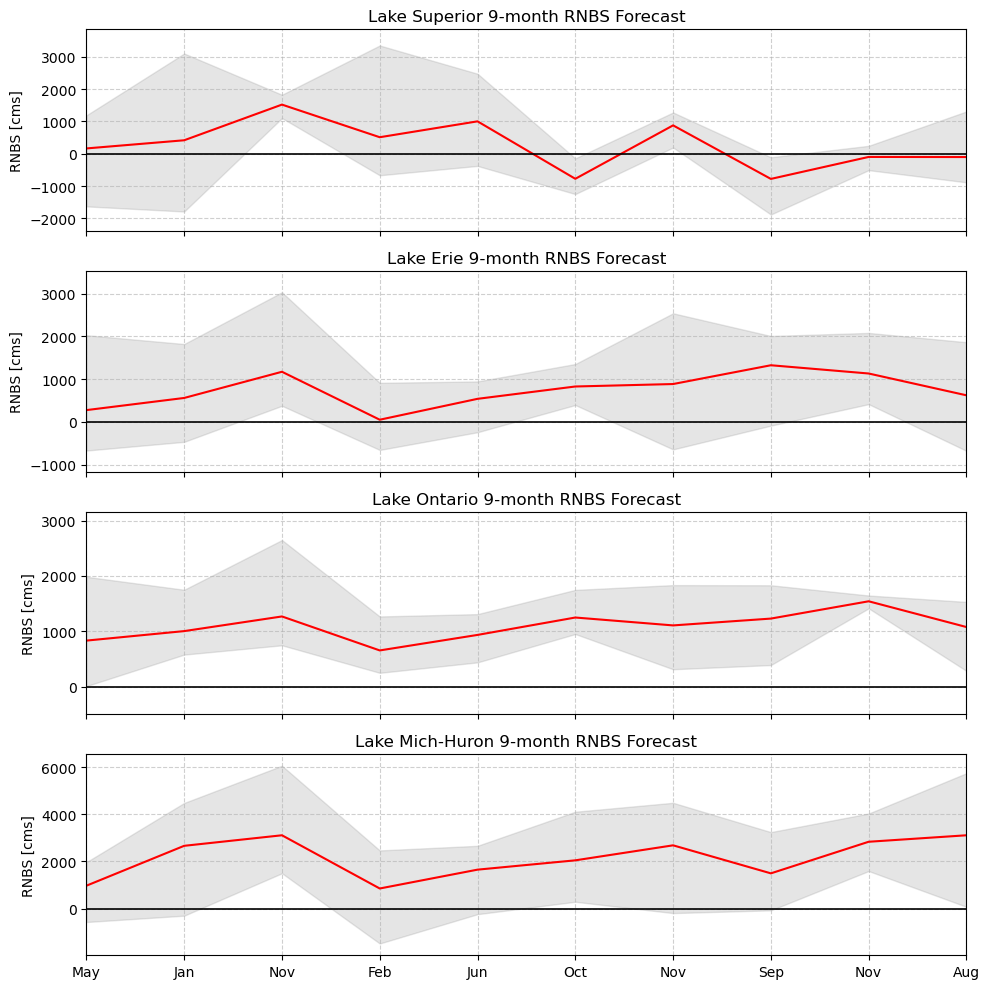

In [10]:
def plot_rnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
    
    # Titles for the subplots
    titles = [
        'Lake Superior 9-month RNBS Forecast',
        'Lake Erie 9-month RNBS Forecast',
        'Lake Ontario 9-month RNBS Forecast',
        'Lake Mich-Huron 9-month RNBS Forecast'
    ]
    
    # Plot each dataset
    for i, (lake_name, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        # Ensure min_val and max_val are scalars

        axs[i].plot(x_values, mean, color='red', linestyle='-', linewidth=1.5, label='Mean')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_ylabel('RNBS [cms]')
        axs[i].set_title(titles[i])
        axs[i].set_xlim(0, 9)  # Setting x-axis limits from 1 to 10
        axs[i].set_ylim(min_val.min()-500, max_val.max()+500)
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i == 3:  # Set labels for the last subplot
            axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],
                                    calendar.month_abbr[df_y_pred['month'][2]], calendar.month_abbr[df_y_pred['month'][3]],
                                    calendar.month_abbr[df_y_pred['month'][4]], calendar.month_abbr[df_y_pred['month'][5]],
                                    calendar.month_abbr[df_y_pred['month'][6]], calendar.month_abbr[df_y_pred['month'][7]],
                                    calendar.month_abbr[df_y_pred['month'][8]], calendar.month_abbr[df_y_pred['month'][9]]])
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(dir+f'RNBS_forecasts.png', bbox_inches='tight')
    plt.show()

# Example usage
x_values = np.arange(len(mean_su['sup']))  # x-axis values
data_dict = {
    'Lake Superior': (mean_su['sup'], min_su['sup'], max_su['sup']),
    'Lake Erie': (mean_er['eri'], min_er['eri'], max_er['eri']),
    'Lake Ontario': (mean_on['ont'], min_on['ont'], max_on['ont']),
    'Lake Mich-Huron': (mean_mh['mih'], min_mh['mih'], max_mh['mih'])
}

plot_rnbs_forecast(x_values, data_dict)